In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("../datasets/final_.csv")
X = df.drop('Environmental_Health_Score', axis=1)
y = df['Environmental_Health_Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)


In [5]:
# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        # self.fc2 = nn.Linear(20,10)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x= self.fc3(x)
        return x

In [6]:
input_size = X_train.shape[1]
nn_model = NeuralNetwork(input_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.01)

# Convert data to DataLoader for batch processing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [7]:
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    epoch_losses = []
    
    for inputs, labels in train_loader:
        # Forward pass
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    # Calculate and log the average loss for the epoch
    average_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    train_losses.append(average_epoch_loss)

    # Print the loss at every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_epoch_loss:.4f}')




Epoch [100/1000], Loss: 171.3634
Epoch [200/1000], Loss: 169.6358
Epoch [300/1000], Loss: 164.6154
Epoch [400/1000], Loss: 162.8560
Epoch [500/1000], Loss: 162.9360
Epoch [600/1000], Loss: 162.1225
Epoch [700/1000], Loss: 162.8136
Epoch [800/1000], Loss: 162.2464
Epoch [900/1000], Loss: 162.3927
Epoch [1000/1000], Loss: 162.2160


In [8]:
import joblib
joblib.dump(scaler,"scaler.joblib")

['scaler.joblib']

In [9]:
# Save the model to a file
torch.save(nn_model.state_dict(), 'neural_network_model.pth')

# Load the model from the file
loaded_nn_model = NeuralNetwork(input_size)
loaded_nn_model.load_state_dict(torch.load('neural_network_model.pth'))


<All keys matched successfully>

In [10]:
# Make an inference for some data
with torch.no_grad():
    nn_prediction = loaded_nn_model(X_test_tensor)


In [11]:
nn_prediction

tensor([[69.3898],
        [33.0231],
        [93.9668],
        ...,
        [67.1278],
        [13.3800],
        [68.4815]])

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Convert the PyTorch tensor to a NumPy array
y_test_np = y_test.values

# Convert the predictions from PyTorch tensor to a NumPy array
nn_prediction_np = nn_prediction.numpy()

# Calculate regression metrics
mse = mean_squared_error(y_test_np, nn_prediction_np)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_np, nn_prediction_np)
r2 = r2_score(y_test_np, nn_prediction_np)

print(f'Mean Squared Error (MSE): {mse:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'R-squared (R2): {r2:.4f}')


Mean Squared Error (MSE): 181.1795
Root Mean Squared Error (RMSE): 13.4603
Mean Absolute Error (MAE): 8.6769
R-squared (R2): 0.7971


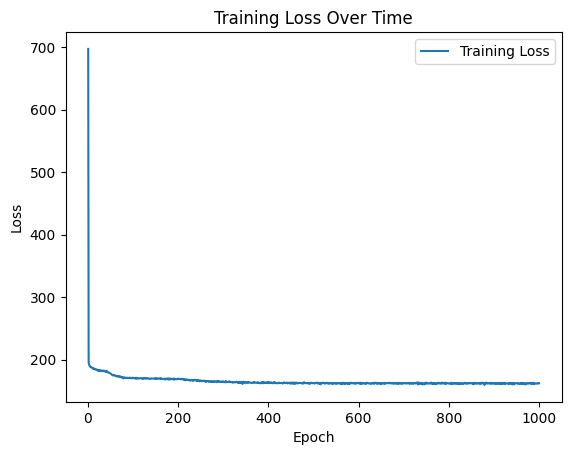

In [13]:
import matplotlib.pyplot as plt
# Plotting the training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()